# CNN for AED with Keras/TensorFlow (restaurant)

Date: Nov 19, 2018

Speech recognition with Keras/TensorFlow

Data acquisition: living room

Feature set: MFCCs

## Preparing data set for CNN

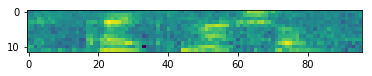

In [41]:
DATASET_FOLDER = '../dataset/data_restaurant/'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.get_shape()
class_labels = ds.get_class_labels()
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.rot90(train_data[8,:,:,0]))

### CNN model

In [42]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 94, 10, 8)         80        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 47, 10, 8)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 45, 8, 16)         1168      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 8, 16)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 6, 32)         4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 6, 32)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 4, 64)          18496     
__________

In [43]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

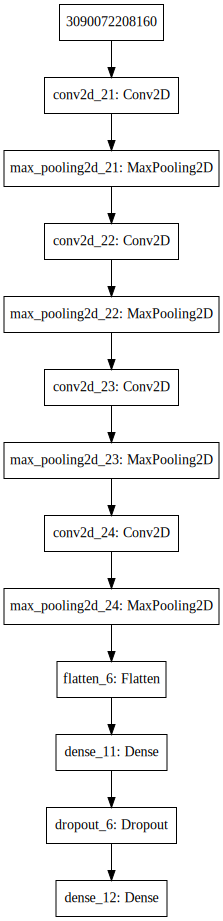

In [44]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [45]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 80 samples, validate on 40 samples
Epoch 1/30
80/80 [==============================] - 5s 58ms/step - loss: 1.4442 - acc: 0.1500 - val_loss: 1.3499 - val_acc: 0.5500
Epoch 2/30
80/80 [==============================] - 4s 48ms/step - loss: 1.3552 - acc: 0.3250 - val_loss: 1.2949 - val_acc: 0.4000
Epoch 3/30
80/80 [==============================] - 4s 46ms/step - loss: 1.2377 - acc: 0.4125 - val_loss: 1.1959 - val_acc: 0.5500
Epoch 4/30
80/80 [==============================] - 4s 48ms/step - loss: 1.1249 - acc: 0.4875 - val_loss: 1.0773 - val_acc: 0.6750
Epoch 5/30
80/80 [==============================] - 4s 48ms/step - loss: 0.9650 - acc: 0.5875 - val_loss: 0.9407 - val_acc: 0.7750
Epoch 6/30
80/80 [==============================] - 4s 45ms/step - loss: 0.9050 - acc: 0.6500 - val_loss: 0.8096 - val_acc: 0.7500
Epoch 7/30
80/80 [==============================] - 4s 49ms/step - loss: 0.6739 - acc: 0.7125 - val_loss: 0.7985 - val_acc: 0.8000
Epoch 8/30
80/80 [=====================

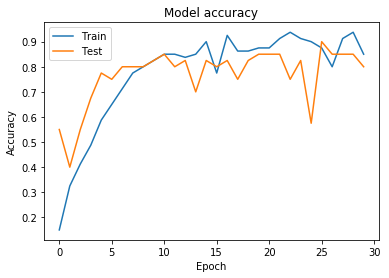

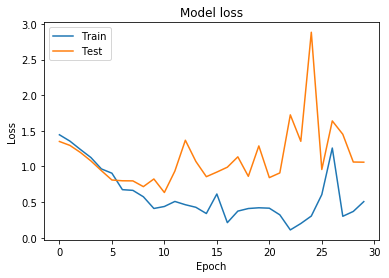

In [46]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [47]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_restaurant_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [48]:
del model
model = models.load_model(filename)

## Confirmation

In [49]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(80, 96, 12, 1)

In [50]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [51]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [52]:
class_labels

['mazui', 'oishii', 'others', 'umai']

In [53]:
(activations[-1][:10]*100).astype(int)

array([[  0,   0,  99,   0],
       [  1,  95,   3,   0],
       [  0, 100,   0,   0],
       [100,   0,   0,   0],
       [  0,   0,  99,   0],
       [ 99,   0,   0,   0],
       [  8,   0,  91,   0],
       [  0,   0,   0, 100],
       [  0,   0,  50,  49],
       [  0,   0,  99,   0]])

In [54]:
test_labels[:10].astype(int)

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [55]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'umai'

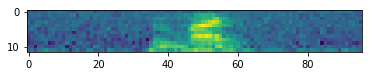

In [56]:
image_number = 7

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

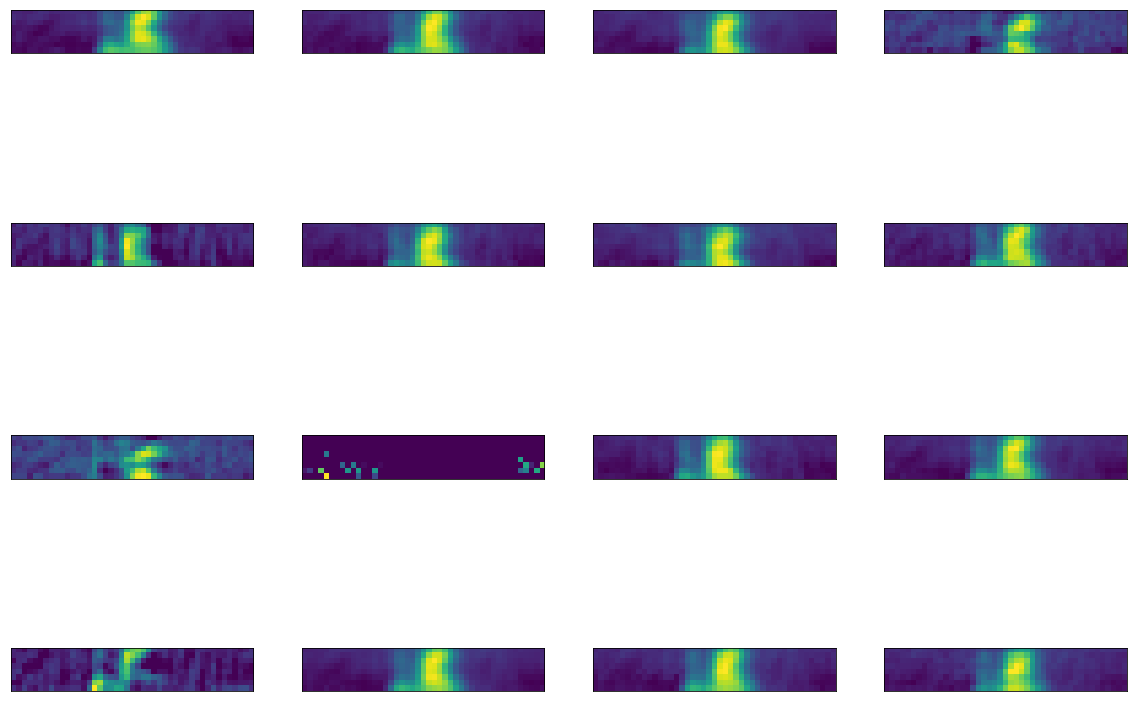

In [57]:
plot_layer(activations, image_number, 2)

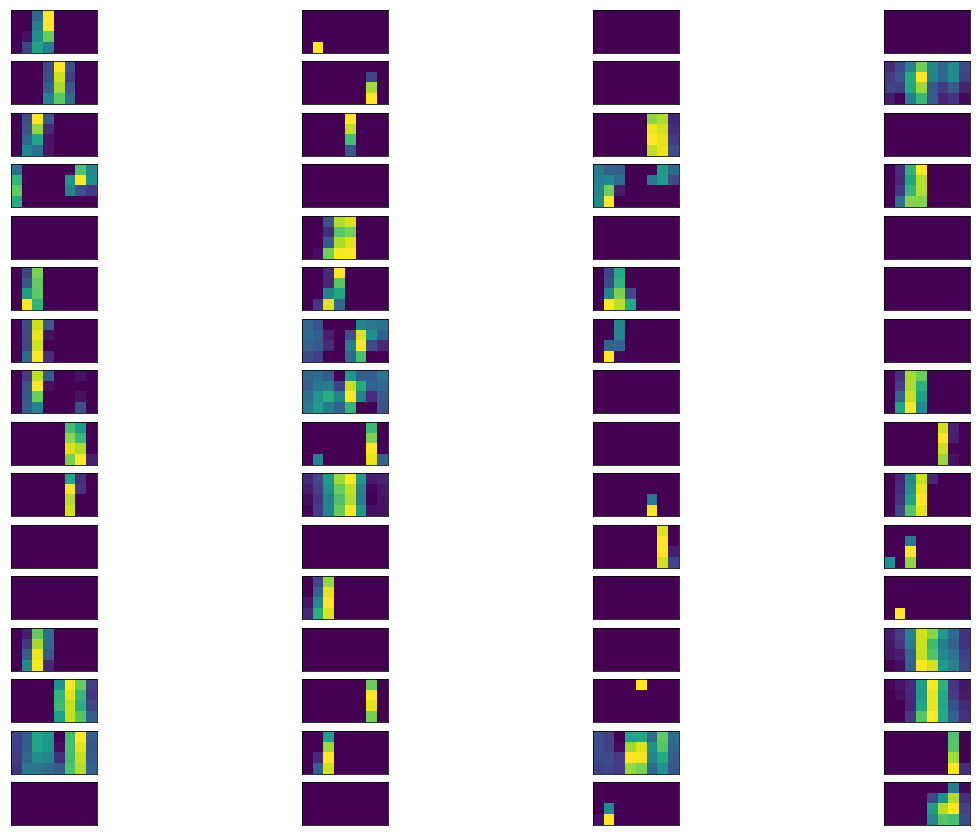

In [58]:
plot_layer(activations, image_number, 6)